In [1]:
import numpy as np
from itertools import cycle
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime as dt
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/development/regional-mom6/")
from pathlib import Path
import regional_mom6 as rm
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40561,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:43457,Total threads: 4
Dashboard: /proxy/42637/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43035,


# Use restarts from 20th degree runs to setup 40th initial condition

In [3]:

## Choose your coordinates and the name of your experiment
yextent = [-56,-26]
xextent = [142,180]
expt_name = "setup-smooth40"

# 
daterange = ["2010-01-01 00:00:00", "2020-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = inputdir + "/tmp"

toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
for i in [rundir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)

In [4]:
expt = rm.experiment(
    longitude_extent = xextent,
    latitude_extent = yextent,
    date_range = daterange,
    resolution = 0.025,  ## Resolution
    number_vertical_layers = 100,      ## #zlayers
    layer_thickness_ratio = 20,       ## dz ratio
    depth = 5500,    ## Max depth of ocean
    mom_run_dir = rundir,
    mom_input_dir = inputdir,
    toolpath_dir = toolpath
)

expt.hgrid

<xarray.Dataset>
Dimensions:   (nyp: 3181, nxp: 3041, nx: 3040, ny: 3180)
Dimensions without coordinates: nyp, nxp, nx, ny
Data variables:
    tile      |S255 b'tile1'
    x         (nyp, nxp) float64 142.0 142.0 142.0 142.0 ... 180.0 180.0 180.0
    y         (nyp, nxp) float64 -56.0 -56.0 -56.0 -56.0 ... -26.0 -26.0 -26.0
    dx        (nyp, nx) float64 388.6 388.6 388.6 388.6 ... 624.6 624.6 624.6
    dy        (ny, nxp) float64 524.5 524.5 524.5 524.5 ... 524.5 524.5 524.5
    area      (ny, nx) float64 8.154e+05 8.154e+05 ... 1.31e+06 1.31e+06
    angle_dx  (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    arcx      |S255 b'small_circle'

## Multiply restart file by the ocean mask
Got to remove the weird stuff going on inside the restart file! Replace it with nans and then interpolate it the normal way

In [6]:
mask = xr.open_mfdataset("/g/data/nm03/ab8992/ttide-inputs/full-20/ocean_mask.nc").mask
restart = xr.open_mfdataset("/g/data/nm03/ab8992/ttide-inputs/restart-smooth20-070/MOM.res.nc",decode_times=False)

varnames = {
     "time":"Time",
     "yq":"latq",
     "xq":"lonq",
     "yh":"lath",
     "xh":"lonh",
     "zl":"Layer",
     "eta":"sfc",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"Salt","temp":"Temp"}
     }



mask = mask.where(mask>0)

restart_masked = xr.Dataset(
    data_vars = dict(
        Temp = (["Layer","yh","xh"],restart.Temp.rename({"lonh":"xh","lath":"yh"}).isel(Time = 0).values),
        Salt = (["Layer","yh","xh"],restart.Salt.rename({"lonh":"xh","lath":"yh"}).isel(Time = 0).values),
        u = (["Layer","yh","xh"],restart.u.interp(lonq = restart.lonh).rename({"lonq":"xh","lath":"yh"}).isel(Time = 0).values),
        v = (["Layer","yh","xh"],restart.v.interp(latq = restart.lath).rename({"lonh":"xh","latq":"yh"}).isel(Time = 0).values),
        sfc = (["yh","xh"],restart.sfc.rename({"lonh":"xh","lath":"yh"}).isel(Time = 0).values),
),
    coords = dict(
        Layer = restart.Layer.values,
        xh = restart.lonh.values,
        yh = restart.lath.values
    )
)

# Multiply each variable in restart by the mask
for var in restart_masked.data_vars.keys():
    restart_masked[var] = restart_masked[var]*mask.values

# mask.plot()

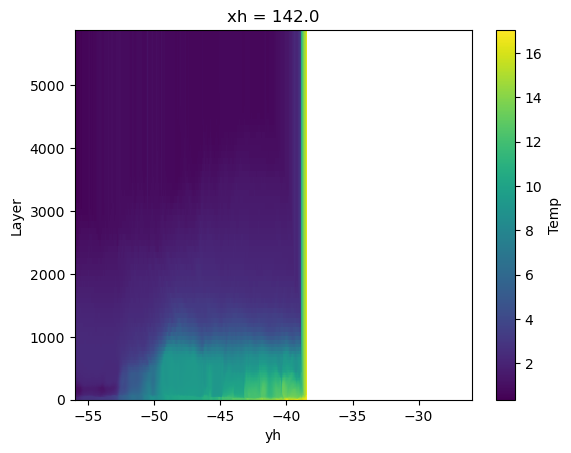

In [102]:
restart_masked.Temp.isel(xh = 0).plot()

In [118]:
ic[var].loc[{"xh":ic.xh[0]}]

<xarray.DataArray 'eta_t' (yh: 1590)>
dask.array<getitem, shape=(1590,), dtype=float64, chunksize=(1590,), chunktype=numpy.ndarray>
Coordinates:
    xh       float64 142.0
  * yh       (yh) float64 -55.99 -55.97 -55.95 -55.93 ... -26.05 -26.03 -26.01

In [12]:
# Save these again


ic_tracers = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/forcing/init_tracers.nc")
ic_vels = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/forcing/init_vel.nc")
ic_eta = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/forcing/init_eta.nc")


for var in ["temp","salt"]:
    ic_tracers[var].loc[{"xh":ic_tracers.xh[0]}] = ic_tracers[var].isel(xh = 1)
    ic_tracers[var].loc[{"yh":ic_tracers.yh[0]}] = ic_tracers[var].isel(yh = 1)
    ic_tracers[var].loc[{"xh":ic_tracers.xh[-1]}] = ic_tracers[var].isel(xh = -2)
    ic_tracers[var].loc[{"yh":ic_tracers.yh[-1]}] = ic_tracers[var].isel(yh = -2)

ic_tracers.to_netcdf("/g/data/nm03/ab8992/ttide-inputs/smooth-40/init_tracers.nc")
ic_tracers.close()
var = "u"
ic_vels[var].loc[{"nxp":ic_vels.nxp[0]}] = ic_vels[var].isel(nxp = 1)
ic_vels[var].loc[{"ny":ic_vels.ny[0]}] = ic_vels[var].isel(ny = 1)
ic_vels[var].loc[{"nxp":ic_vels.nxp[-1]}] = ic_vels[var].isel(nxp = -2)
ic_vels[var].loc[{"ny":ic_vels.ny[-1]}] = ic_vels[var].isel(ny = -2)

var = "v"
ic_vels[var].loc[{"nx":ic_vels.nx[0]}] = ic_vels[var].isel(nx = 1)
ic_vels[var].loc[{"nyp":ic_vels.nyp[0]}] = ic_vels[var].isel(nyp = 1)
ic_vels[var].loc[{"nx":ic_vels.nx[-1]}] = ic_vels[var].isel(nx = -2)
ic_vels[var].loc[{"nyp":ic_vels.nyp[-1]}] = ic_vels[var].isel(nyp = -2)
ic_vels.to_netcdf("/g/data/nm03/ab8992/ttide-inputs/smooth-40/init_vel.nc")

ic_eta.eta_t.loc[{"xh":ic_eta.xh[0]}] = ic_eta.eta_t.isel(xh = 1)
ic_eta.eta_t.loc[{"yh":ic_eta.yh[0]}] = ic_eta.eta_t.isel(yh = 1)
ic_eta.eta_t.loc[{"xh":ic_eta.xh[-1]}] = ic_eta.eta_t.isel(xh = -2)
ic_eta.eta_t.loc[{"yh":ic_eta.yh[-1]}] = ic_eta.eta_t.isel(yh = -2)
ic_eta.to_netcdf("/g/data/nm03/ab8992/ttide-inputs/smooth-40/init_eta.nc")


In [87]:
zero_coords = restart_masked.Salt.where(restart_masked.Salt == 0, drop=True)
zero_coords

<xarray.DataArray 'Salt' (Layer: 0, yh: 0, xh: 0)>
array([], shape=(0, 0, 0), dtype=float64)
Coordinates:
  * Layer    (Layer) float64 
  * xh       (xh) float64 
  * yh       (yh) float64

In [93]:
salt.isel(xh = 0).values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [88]:
salt = ic.salt.load()
zero_coords = salt.where(salt.load() == 0, drop=True)
zero_coords


<xarray.DataArray 'salt' (zl: 100, yh: 1590, xh: 1520)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
...
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * xh       (xh) float64 142.0 142.0 142.1 142.1 ... 179.9 179.9 180.0 180.0
  * yh       (yh) float64 -55.99 -55.97 -55.95 -55.93 ... -26.05 -26.03 -26.01
  * zl       (zl) float64 8.073 13.49 18.94 ... 5.241e+03 5.345e+03 5.448e+03

In [86]:
zero_coords

<xarray.DataArray 'salt' (zl: 100, yh: 1590, xh: 1520)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
...
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        ...,
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0., nan, nan, ..., nan, nan,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * xh       (xh) float64 142.0 142.0 142.1 142.1 ... 179.9 179.9 180.0 180.0
  * yh       (yh) float64 -55.99 -55.97 -55.95 -55.93 ... -26.05 -26.03 -26.01
  * zl       (zl) float64 8.073 13.49 18.94 ... 5.241e+03 5.345e+03 5.448e+03

In [9]:
restart_masked.to_netcdf("/g/data/nm03/ab8992/ttide-inputs/restart-smooth20-070/MOM.res.masked.nc")

In [10]:


varnames = {
     "time":"Time",
     "y":"yh",
     "x":"xh",
     "zl":"Layer",
     "eta":"sfc",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"Salt","temp":"Temp"}
     }

expt.initial_condition(
    "/g/data/nm03/ab8992/ttide-inputs/resart-full20-070/MOM.res.masked.nc",
    varnames = varnames,
    gridtype="A"
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done setting up initial condition.


In [4]:
tmpdir = Path(f"/g/data/nm03/ab8992/glorys-download/tenyears")

varnames = {"time":"time","y":"latitude","x":"longitude",
     "zl":"depth","eta":"zos","u":"uo","v":"vo",
     "tracers":{"salt":"so","temp":"thetao"}}


for i,orientation in enumerate(["south","north","west","east"]):
    expt.setup_rectangular_boundary(
        tmpdir / (orientation + "_unprocessed.nc"),
        varnames,
        orientation,
        i + 1
        )

Processing south boundary...0.3.0
Done.
Processing north boundary...Done.
Processing west boundary...Done.
Processing east boundary...Done.


In [6]:
expt.setup_era5("/g/data/rt52/era5/single-levels/reanalysis")


In [5]:
expt.bathymetry(
    '/g/data/v45/ab8992/synbath2/SYNBATH_V1.2.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"z"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1,
    #  maketopog=False
    )

Starting to regrid bathymetry. If this process hangs you might be better off calling ESMF directly from a terminal with appropriate computational resources using 

 mpirun ESMF_Regrid -s bathy_original.nc -d topog_raw.nc -m bilinear --src_var elevation --dst_var elevation --netcdf4 --src_regional --dst_regional

This is better for larger domains.


Reading in regridded bathymetry to fix up metadata...done.


In [7]:
expt.FRE_tools((40,40))


NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=1600

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 1600
max_pe = 1600
layout = 40, 40
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>N

In [8]:
expt.setup_run_directory("",using_payu=True)

Number of CPUs required:  1435


## Add Tides to an Existing Run
Offline I've copied all the inputs from the ttide-20 run. All that this notebook does is use the out-of-the-box NWA scripts to add tidal constituents. I'll then need to go back to the MOM_input file from my old tide test to rectify the new one 

In [4]:
import os
import xarray as xr
os.chdir("/home/149/ab8992/cosima_regional/development/withtides/regional-mom6/")
os.listdir()
import boundary_tides as bt

In [8]:
## VERBATIM COPY OLD CODE AND SEE WHAT HAPPENS

# """
# constituents in TPXO9:
# con =
# "m2  ",  0
# "s2  ",  1
# "n2  ",  2
# "k2  ",  3
# "k1  ",  4
# "o1  ",  5
# "p1  ",  6
# "q1  ",  7
# "mm  ",  8
# "mf  ",  9
# "m4  ", 10
# "mn4 ", 11
# "ms4 ", 12
# "2n2 ", 13
# "s1  "  14
# """
# Use these constituents:
# (MOM6 does not currently support m4, mn4, ms4, 2n2, or s1.)
# constituents = range(0, 10)

constituents = [0]

# Hardcoded for my ttide domain!!! 

horizontal_subset = dict(ny=slice(200,380), nx=slice(850,1100))

# Path to tpxo9.v1 data
tpxo_dir = '/g/data/nm03/TPXO'

# Save output here
output_dir = inputdir + "/forcing"

# Setup NWA boundaries
hgrid = xr.open_dataset(inputdir + '/hgrid.nc')
# segments taken from nwa25_obc.py
segments = [
    bt.Segment(1, 'south', hgrid, output_dir=output_dir),
    bt.Segment(2, 'north', hgrid, output_dir=output_dir),
    bt.Segment(3, 'west', hgrid, output_dir=output_dir),
    bt.Segment(4, 'east', hgrid, output_dir=output_dir)
]
# reload(bt)
bt.write_tpxo(constituents, tpxo_dir, segments, horizontal_subset,"tpxo9.v1.nc")

## Regrid era


In [9]:
expt.daterange[0].year

2015

In [12]:
ls /g/data/

hh5/  nm03/  v45/  x77/
